In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import heapq
import re
import concurrent.futures
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error



In [3]:
keyTestTPath = 'data/key_test_t.csv'
df = pd.read_csv(keyTestTPath,encoding="unicode_escape")
# df = df[:1000]

In [4]:
def validate_json(json_str):
    try:
        json.loads(json_str)
        return True
    except:
        return False

def process_row(row):
    if validate_json(row.dimension) and validate_json(row.results):
        return row
    else:
        return None

def judgeJson(keyTestT):
    # 使用并行处理加速处理过程
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_row, keyTestT.itertuples()), total=len(keyTestT)))

    # 过滤掉返回 None 的结果并重置索引
    keyTestT = pd.DataFrame([r for r in results if r is not None])
    keyTestT = keyTestT.reset_index(drop=True)
    return keyTestT


try:
    df = pd.read_csv('data/filterFile.csv', index_col=None)
    print('filterFile.csv exists')
except FileNotFoundError:
    df = df[['results', 'dimension','results_key']]
    df = judgeJson(df)
    df.to_csv('data/filterFile.csv', index=False)
    print('filterFile.csv created')

filterFile.csv exists


In [5]:
filterFilePath = 'data/filterFile.csv'
df = pd.read_csv(filterFilePath)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640166 entries, 0 to 640165
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Index        640166 non-null  int64 
 1   results      640166 non-null  object
 2   dimension    640166 non-null  object
 3   results_key  640166 non-null  object
dtypes: int64(1), object(3)
memory usage: 19.5+ MB


In [7]:
df.head()

,Index,results,dimension,results_key
0,0,"{""#wrk_qps_avg"": 1547599.39, ""wrk_latency_avg""...","{""cvm_cpu"": ""62"", ""platform"": ""qcloud"", ""test_...",test_1kb
1,1,"{""openssl_des_size_16"": 27246690.0, ""openssl_d...","{""cvm_cpu"": ""32"", ""platform"": ""qcloud"", ""test_...",default
2,2,"{""#ls_time"": 18}","{""dd"": ""name_11"", ""cvm_cpu"": ""1"", ""platform"": ...",default
3,3,"{""#ls_time"": 18}","{""dd"": ""name_11"", ""cvm_cpu"": ""1"", ""platform"": ...",default
4,4,"{""#mlc_idle_latency"": 90.6}","{""cvm_cpu"": ""8"", ""platform"": ""default"", ""test_...",specific_actions=idle_latency


In [8]:
def getKeyNum(df):
    # 提取 results 列中带有 "#" 号的字段
    pattern = r'#\w+'  
    results = df['results'].str.cat(sep=' ')  # 将所有 results 列的数据合并为一个字符串
    hashtags = set(re.findall(pattern, results))  # 使用正则表达式提取带 "#" 号的字段，并去重

    # 统计每个带 "#" 号的字段在整个文件中出现的次数
    hashtags_dict = {}
    for hashtag in hashtags:
        count = results.count(hashtag)
        hashtags_dict[hashtag] = count
    return hashtags_dict

def showKeyNum(hashtags_dict):
    # 将字典按值从大到小排序
    hashtags_dict_sorted = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)

    # 提取排序后的键和值
    hashtags_sorted = [item[0] for item in hashtags_dict_sorted]
    counts_sorted = [item[1] for item in hashtags_dict_sorted]

    # 绘制柱状图
    plt.figure(figsize=(180, 25))  
    plt.bar(hashtags_sorted, counts_sorted)  
    plt.xticks(rotation=90)  
    plt.xlabel('Hashtags')  
    plt.ylabel('Counts')  
    plt.title('Hashtags Counts')  
    plt.show()

def getTop10Key(hashtags_dict):
    # 获取字典中数量前十的字段
    top_n = 10  # 自定义获取前几个字段
    top_n_fields = heapq.nlargest(top_n, hashtags_dict, key=hashtags_dict.get)
    
    print("数量前十的字段：")
    for field in top_n_fields:
        print("字段名: {:<30s} 出现次数: {:d}".format(field, hashtags_dict[field]))

In [9]:
hashtags_dict=getKeyNum(df)

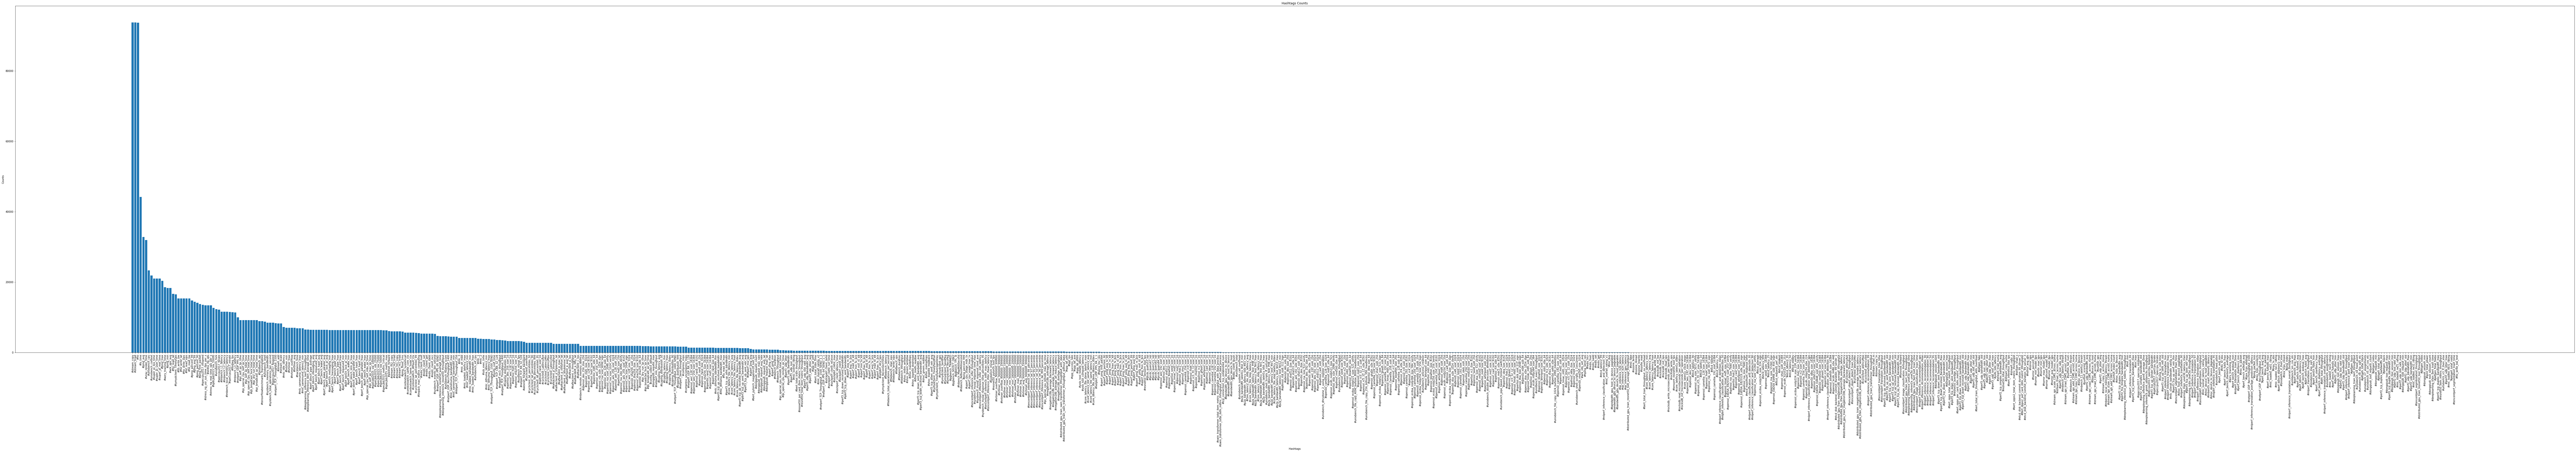

In [10]:
showKeyNum(hashtags_dict)

In [11]:
getTop10Key(hashtags_dict)

数量前十的字段：
字段名: #stream_copy                   出现次数: 93794
字段名: #stream_triad                  出现次数: 93794
字段名: #fio                           出现次数: 93701
字段名: #ls_time                       出现次数: 44230
字段名: #ping_avg                      出现次数: 32806
字段名: #vray_render_time              出现次数: 31939
字段名: #unixbench_cpu                 出现次数: 23346
字段名: #unixbench_context             出现次数: 21923
字段名: #super_pi_sys_time             出现次数: 20996
字段名: #super_pi_user_time            出现次数: 20996


In [149]:
def getValue1(df, field):
    result_dict_values = {}
    result_dict_values[field] = []
    for row in df.itertuples():
        if field in row.results:
            try:
                result = eval(row.results)[field]
                result_dict_values[field].append(result)
            except:
                pass
    return result_dict_values

def getValue2(df, field):
    result_dict_values = {field: df.loc[df['results'].str.contains(field), 'results'].str.extract(r'\"{}\":\s*(\d+)'.format(field), expand=False).dropna().astype(float).tolist()}
    return result_dict_values

In [14]:
def get_input_output_Speed(Tdf, field):
    # 选择需要提取的字段
    df = Tdf.copy()
    #keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
    keys_to_extract = []

    # 对dimension列进行预处理
    df['dimension'] = df['dimension'].apply(lambda x: json.loads(x))
    for key in keys_to_extract:
        df[key] = df['dimension'].apply(lambda x: x.get(key, None))

    # # 对cvm_memory和cvm_cpu进行数值化处理
    # df[['cvm_cpu', 'cvm_memory']] = df[['cvm_cpu', 'cvm_memory']].apply(pd.to_numeric, errors='coerce').fillna(-1)

    # 筛选出符合要求的行
    df_filtered = df[df['results'].str.contains(field)]

    # 从results中提取出field对应的值
    df_output = pd.DataFrame(df_filtered['results'].apply(lambda x: json.loads(x)).tolist(), index=df_filtered.index)
    df_output = df_output[field]

    # 将input和output分别转成dataframe
    df_input = df_filtered[keys_to_extract + ['results_key']]
    df_output = pd.DataFrame(df_output)

    return df_input, df_output



In [150]:
#unixbench_cpu
your_field = '#unixbench_cpu'
inputDF, outPutDF = get_input_output_Speed(df, your_field)
print("finish")

finish


In [17]:
inputDF.head()

,results_key
110,"gcc_oflag=O0,threads=1"
152,"gcc_oflag=O0,threads=8"
238,"gcc_oflag=O0,threads=1"
248,"gcc_oflag=O0,threads=124"
264,"gcc_oflag=O3,threads=124"


In [18]:
outPutDF.head()

,#unixbench_cpu
110,2364
152,18835
238,3265
248,317646
264,788652


In [151]:
print(inputDF.shape)
print(outPutDF.shape)

(23346, 1)
(23346, 1)


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor



import pickle
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve

In [122]:
def showPic(methodName, y_test, y_pred):
    # 创建柱状图
    #plt.figure(figsize=(80, 15))
    plt.subplot(1, 2, 1)
    # 创建样本索引数组
    index = np.arange(len(y_test))
    # 绘制线性回归模型的折线图
    plt.plot(index, y_test, label='True Values')
    plt.plot(index, y_pred, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title('{}: True Values vs. Predicted Values'.format(methodName))
    plt.legend()
    plt.show()



def showCoef(linear_reg, decision_tree_reg, random_forest_reg):
    # 绘制特征重要性条形图
    if len(linear_reg.coef_) > 1:
        coef_abs = np.abs(linear_reg.coef_)
        sorted_idx = np.argsort(coef_abs)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(coef_abs)), coef_abs[sorted_idx])
        plt.xticks(range(len(coef_abs)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance (by coefficient absolute value)')
        plt.title('Linear Regression - Feature Importance')
        plt.show()
    else:
        print('Linear Regression - No feature importance to plot')

    if len(decision_tree_reg.feature_importances_) > 1:
        feature_importances = decision_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Decision Tree - Feature Importance')
        plt.show()
    else:
        print('Decision Tree - No feature importance to plot')

    if len(random_forest_reg.feature_importances_) > 1:
        feature_importances = random_forest_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Random Forest - Feature Importance')
        plt.show()
    else:
        print('Random Forest - No feature importance to plot')

def showCoef_new( decision_tree_reg):
    # 绘制特征重要性条形图
    if len(decision_tree_reg.feature_importances_) > 1:
        feature_importances = decision_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        #plt.figure(figsize=(150, 20))
        plt.figure()
        last_five=sorted_idx[-5:]
        plt.bar(range(5), feature_importances[last_five])
        plt.xticks(range(5), last_five)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Decision Tree - Feature Importance')
        plt.show()
    else:
        print('Decision Tree - No feature importance to plot')



def getCoef( decison_tree_reg):
    result = []
    # 
    if len(decison_tree_reg.feature_importances_) > 1:
        feature_importances = decison_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    return result


def getFeatureName(result, inputDF):
    feature_names = inputDF.columns
    linear_reg_indices = result[0]  # 线性回归模型的特征索引
    decision_tree_indices = result[1]  # 决策树模型的特征索引
    random_forest_indices = result[2]  # 随机森林模型的特征索引

    linear_reg_feature_names = feature_names[linear_reg_indices].tolist()  # 线性回归模型的特征列名列表
    decision_tree_feature_names = feature_names[decision_tree_indices].tolist()  # 决策树模型的特征列名列表
    random_forest_feature_names = feature_names[random_forest_indices].tolist()  # 随机森林模型的特征列名列表
    
    linear_reg_features = inputDF[linear_reg_feature_names]  # 线性回归模型的特征值
    decision_tree_features = inputDF[decision_tree_feature_names]  # 决策树模型的特征值
    random_forest_features = inputDF[random_forest_feature_names]  # 随机森林模型的特征值


def showDecisonTree(decision_tree_reg, flag=False):
    if flag:    
        plt.figure(figsize=(20, 10))  # 设置画布大小
        plot_tree(decision_tree_reg, max_depth=2, feature_names=None, filled=True, rounded=True)  # 设置最大深度为2，可以根据需要调整
        plt.title('Decision Tree')
        plt.show()


def showRandomForest(random_forest_reg, flag=False):
    if flag:
        if len(random_forest_reg.feature_importances_) > 1:
            # 获取特征重要性
            feature_importances = random_forest_reg.feature_importances_
            # 选择特征重要性最高的决策树
            best_tree_index = np.argmax(feature_importances)
            if best_tree_index >= random_forest_reg.n_estimators:
                best_tree_index = random_forest_reg.n_estimators - 1

            plt.figure(figsize=(20, 10))
            plot_tree(random_forest_reg.estimators_[best_tree_index], max_depth=2, feature_names=None, filled=True, rounded=True)
            plt.title('Best Decision Tree')
            plt.show()
        else:
            print('Random Forest - No feature importance to plot')


def getModel(X_train, y_train, save_path):
    # 初始化模型
    decision_tree_reg = DecisionTreeRegressor(splitter="best")  #“random”表示分枝时会更加随机，常用来防止过拟合
    knn_reg = KNeighborsRegressor(n_neighbors=7)    #应该是比较适合大量数据
    xgb_reg = xgb.XGBRegressor()
    params = {
    'n_estimators': 400, 
    'max_depth': 11,
    'learning_rate': 0.06,
    'loss': 'ls',
    'subsample':0.8
     }
    gbdt_reg=GradientBoostingRegressor(**params)

    # 拟合模型
    decision_tree_reg.fit(X_train, y_train)
    knn_reg.fit(X_train, y_train)
    xgb_reg.fit(X_train, y_train)
    gbdt_reg.fit(X_train, y_train)

    # 保存模型
    models = {
        #'linear_reg': linear_reg,
        'decision_tree_reg': decision_tree_reg,
        'knn_reg': knn_reg,
        'xgb_reg':xgb_reg,
        'gbdt_reg':gbdt_reg
    }
    # save_path = 'model/'
    for model_name, model in models.items():
        with open(save_path + model_name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

    #return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg, xgb_reg, gbm_reg, gbdt_reg
    return decision_tree_reg, knn_reg, xgb_reg, gbdt_reg


def train(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    #linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg, xgb_reg, gbm_reg, gbdt_reg = getModel(X_train, y_train, save_path)
    decision_tree_reg, knn_reg, xgb_reg, gbdt_reg = getModel(X_train, y_train, save_path)

    # # 绘制KNN的学习曲线,选出最优的K值  #已选出:7
    # plt.figure()
    # score = []
    # krange = range(1,20,1)
    # for i in krange:
    #     clf = KNeighborsRegressor(n_neighbors = i)#n_neighbors：取邻近点的个数k
    #     clf.fit(X_train, y_train)
    #     score.append(clf.score(X_test, y_test))
    # plt.plot(krange, score)
    
    # 预测
    #y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)
    y_pred_xgb_reg = xgb_reg.predict(X_test)
    y_pred_gbdt_reg = gbdt_reg.predict(X_test)

    #用R^2判断模型的拟合程度，MAPE判断预测值的误差。较好模型的R^2应高于0.8，或者MAPE低于5%
    # 计算评估指标  越接近1模型越好
    #r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)
    r2_xgb_reg = r2_score(y_test, y_pred_xgb_reg)
    r2_gbdt_reg = r2_score(y_test, y_pred_gbdt_reg)

    #计算MAPE指标  越接近0模型越好,大于1就是劣质模型
    #Linear_MAPE = mean_absolute_percentage_error(y_test, y_pred_linear_reg)
    Decision_tree_MAPE = mean_absolute_percentage_error(y_test, y_pred_decision_tree_reg)
    Knn_MAPE = mean_absolute_percentage_error(y_test, y_pred_knn_reg)
    xgb_MAPE = mean_absolute_percentage_error(y_test, y_pred_xgb_reg)
    gbdt_MAPE = mean_absolute_percentage_error(y_test, y_pred_gbdt_reg)

    #print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('{:<30} {:>10}'.format('XGBOOST R2:', '{:.8f}'.format(r2_xgb_reg)))
    print('{:<30} {:>10}'.format('GBDT R2:', '{:.8f}'.format(r2_gbdt_reg)))
    print('\n')

    #print('{:<30} {:>10}'.format('Linear Regression MAPE:', '{:.8f}'.format(Linear_MAPE)))
    print('{:<30} {:>10}'.format('Decision Tree MAPE:', '{:.8f}'.format(Decision_tree_MAPE)))
    print('{:<30} {:>10}'.format('KNN MAPE:', '{:.8f}'.format(Knn_MAPE)))
    print('{:<30} {:>10}'.format('XGBOOST MAPE:', '{:.8f}'.format(xgb_MAPE)))
    print('{:<30} {:>10}'.format('GBDT MAPE:', '{:.8f}'.format(gbdt_MAPE)))
    print('\n')
    
    
    models = []
    getModelList = []
    
    if r2_decision_tree_reg > 0.8:
        models.append("Decision Tree Regression")
        getModelList.append("decision_tree_reg")
    if r2_knn_reg > 0.8:
        models.append("KNN Regression")
        getModelList.append("knn_reg")
    if r2_xgb_reg > 0.8:
        models.append("XGB Regressor")
        getModelList.append("xgb_reg")
    if r2_gbdt_reg > 0.8:
        models.append("GBDT")
        getModelList.append("gbdt_reg")
        
    for i in range(len(models)):
        judgeResult(eval(getModelList[i]), X_train, y_train, X_test, y_test)
        
    return decision_tree_reg, knn_reg ,xgb_reg , gbdt_reg


def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
   
    # 判断过拟合
    if train_scores_mean.all() < test_scores_mean.all():
        print("模型可能存在过拟合的问题\n\n")
    else:
        print("模型可能没有过拟合的问题\n\n")
         #画图
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label=model.__class__.__name__+": Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
                 label="Cross-validation score")
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()


def judgeResult(model, X_train, y_train, X_test, y_test):
    # 在训练集和测试集上计算评估指标
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print('Model: {}'.format(model.__class__.__name__))
    print('{:<30} {:>10}'.format('Train R2:', '{:.8f}'.format(r2_train)))
    print('{:<30} {:>10}'.format('Test R2:', '{:.8f}'.format(r2_test)))
    
    #绘制学习曲线
    plot_learning_curve(model, X_train, y_train)




In [126]:
#inputDF['cvm_cpu'] = pd.to_numeric(inputDF['cvm_cpu'])
#inputDF['cvm_memory'] = pd.to_numeric(inputDF['cvm_memory'])
#one_hot_df = pd.get_dummies(inputDF, columns=['cvm_cpu_qos', 'cvm_os_type','results_key'])
one_hot_df = pd.get_dummies(inputDF, columns=['results_key'])
X = one_hot_df
y = outPutDF
print(X.shape)
print(y.shape)

(23346, 132)
(23346, 1)


1.  观察训练集和测试集上的模型性能：如果模型在训练集上表现很好但在测试集上表现较差，可能是模型过拟合了。可以通过比较训练集和测试集上的评估指标（如R2分数）来观察模型的性能差异。如果模型在训练集上的性能远远优于测试集，可能存在过拟合的问题。

2.  绘制学习曲线：可以绘制模型的学习曲线，观察模型在训练集和测试集上的性能随着训练样本数量增加而变化。如果模型在训练集上的性能持续提高而在测试集上的性能趋于稳定，可能存在过拟合的问题。

d:\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Decision Tree R2:              0.95864945
KNN R2:                        0.94772444
XGBOOST R2:                    0.95326457
GBDT R2:                       0.95790316


Decision Tree MAPE:            0.20579527
KNN MAPE:                      0.21951960
XGBOOST MAPE:                  0.43690769
GBDT MAPE:                     0.34656008


Model: DecisionTreeRegressor
Train R2:                      0.95401139
Test R2:                       0.95864945
模型可能没有过拟合的问题




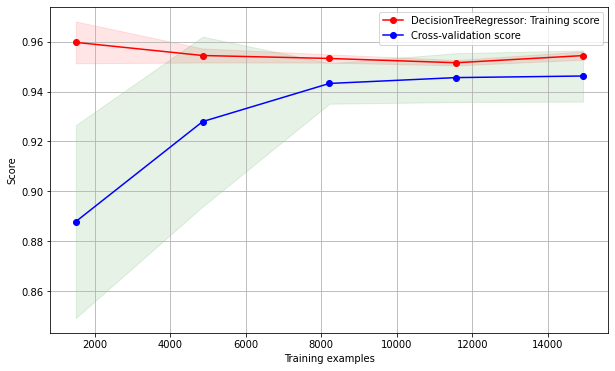

Model: KNeighborsRegressor
Train R2:                      0.94142334
Test R2:                       0.94772444
模型可能没有过拟合的问题




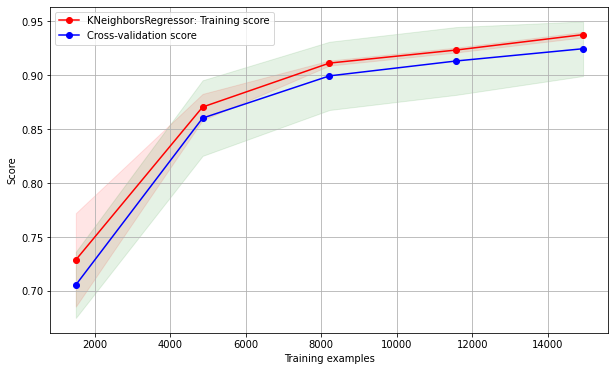

Model: XGBRegressor
Train R2:                      0.95022491
Test R2:                       0.95326457
模型可能没有过拟合的问题




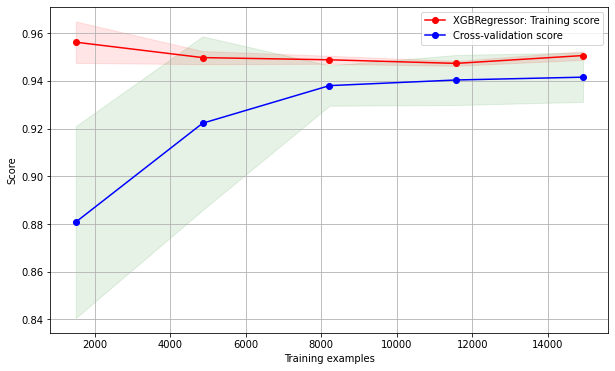

Model: GradientBoostingRegressor
Train R2:                      0.95300466
Test R2:                       0.95790316
模型可能没有过拟合的问题




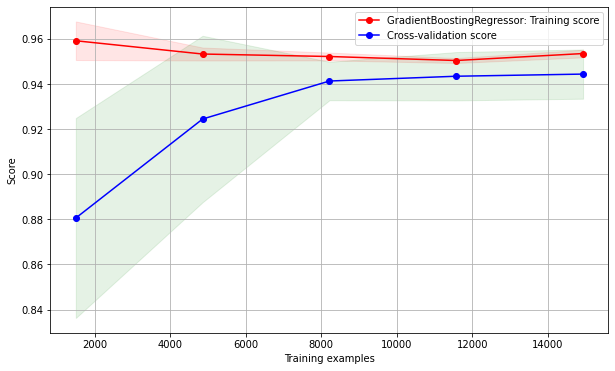

In [127]:
save_path = 'model/'
# 判断是否有这个文件夹，没有就创建 
if not os.path.exists(save_path):
    os.makedirs(save_path)
decision_tree_reg, knn_reg, xgb_reg, gbdt_reg= train(X, y, save_path)

In [42]:
print(inputDF.shape)
print(outPutDF.shape)

(23346, 1)
(23346, 1)


In [43]:
new=pd.concat([inputDF,outPutDF],axis=1)
new.to_csv('D:\\Github\\PerformanceDataAnalysis\\coding\\data\\x and y columns.csv')   #需要通过\\进行转义
new.head()

,results_key,#unixbench_cpu
110,"gcc_oflag=O0,threads=1",2364
152,"gcc_oflag=O0,threads=8",18835
238,"gcc_oflag=O0,threads=1",3265
248,"gcc_oflag=O0,threads=124",317646
264,"gcc_oflag=O3,threads=124",788652


In [45]:
# values=inputDF.T
# b=outPutDF.T
#print(inputDF.iloc[5].at['results_key'])
#print(values.shape)
#print(values[0],"\n\n")
#print(values[0].to_string[:10],"\n")
value_cnt = {}  # 将结果用一个字典存储
value_out = {}  

# 统计结果
n=len(inputDF)
#print(n)
for i in range(n):
	# get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
	v=inputDF.iloc[i].at['results_key']
	value_cnt[v] = value_cnt.get(v, 0) + 1

	v2=outPutDF.iloc[i].at['#unixbench_cpu']
	value_out[v2] = value_out.get(v2, 0) + 1

value_x=list(value_cnt)
value_y=list(value_out)
# 打印输出结果
print(value_x)
print(value_y)
print("在result_key中共有",len(value_x),"个不同的特征")
print("在#unixbench_cpu中共有",len(value_y),"个不同的特征")
#print([key for key in value_cnt.keys()])
#print([value for value in value_cnt.values()])


['gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=8', 'gcc_oflag=O0,threads=124', 'gcc_oflag=O3,threads=124', 'gcc_oflag=O0,threads=1,which_core_to_bind=0', 'gcc_oflag=O3,threads=1,which_core_to_bind=0', 'gcc_oflag=O3,threads=1', 'gcc_oflag=O3,threads=96', 'gcc_oflag=O0,threads=72', 'gcc_oflag=O0,threads=18', 'gcc_oflag=O0,threads=32', 'gcc_oflag=O3,threads=32', 'gcc_oflag=O0,threads=16', 'gcc_oflag=O3,threads=16', 'gcc_oflag=O0,threads=36', 'gcc_oflag=O3,threads=8', 'gcc_oflag=O3,threads=128', 'gcc_oflag=O0,threads=128', 'gcc_oflag=O0,threads=96', 'gcc_oflag=O0,threads=14', 'gcc_oflag=O3,threads=14', 'gcc_oflag=O0,threads=4', 'gcc_oflag=O3,threads=4', 'gcc_oflag=O0,threads=6', 'gcc_oflag=O3,threads=6', 'gcc_oflag=O0,threads=208', 'gcc_oflag=O3,threads=208', 'gcc_oflag=O0,threads=48', 'gcc_oflag=O3,threads=62', 'gcc_oflag=O0,threads=64', 'gcc_oflag=O0,threads=62', 'gcc_oflag=O3,threads=64', 'gcc_oflag=O0,threads=76', 'gcc_oflag=O0,threads=60', 'gcc_oflag=O0,threads=232', 'gcc_oflag=O3,t

In [ ]:
#将特征转化为str方便画图
value_x=[]
value_y=[]
for i in range(n):
	# get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
	v=inputDF.iloc[i].at['results_key']
	value_x.append(v)
	v2=outPutDF.iloc[i].at['#unixbench_cpu']
	value_y.append(v2)

print(value_x)
print(value_y)
print(len(value_x))
print(len(value_y))

['gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=8', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=124', 'gcc_oflag=O3,threads=124', 'gcc_oflag=O0,threads=1,which_core_to_bind=0', 'gcc_oflag=O3,threads=1,which_core_to_bind=0', 'gcc_oflag=O3,threads=1', 'gcc_oflag=O3,threads=1', 'gcc_oflag=O3,threads=96', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=72', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=18', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=32', 'gcc_oflag=O3,threads=1', 'gcc_oflag=O3,threads=32', 'gcc_oflag=O0,threads=1,which_core_to_bind=0', 'gcc_oflag=O3,threads=1,which_core_to_bind=0', 'gcc_oflag=O3,threads=1', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=16', 'gcc_oflag=O3,threads=1', 'gcc_oflag=O3,threads=16', 'gcc_oflag=O0,threads=1,which_core_to_bind=0', 'gcc_oflag=O3,threads=1,which_core_to_bind=0', 'gcc_oflag=O0,threads=1', 'gcc_oflag=O0,threads=8', 'gcc

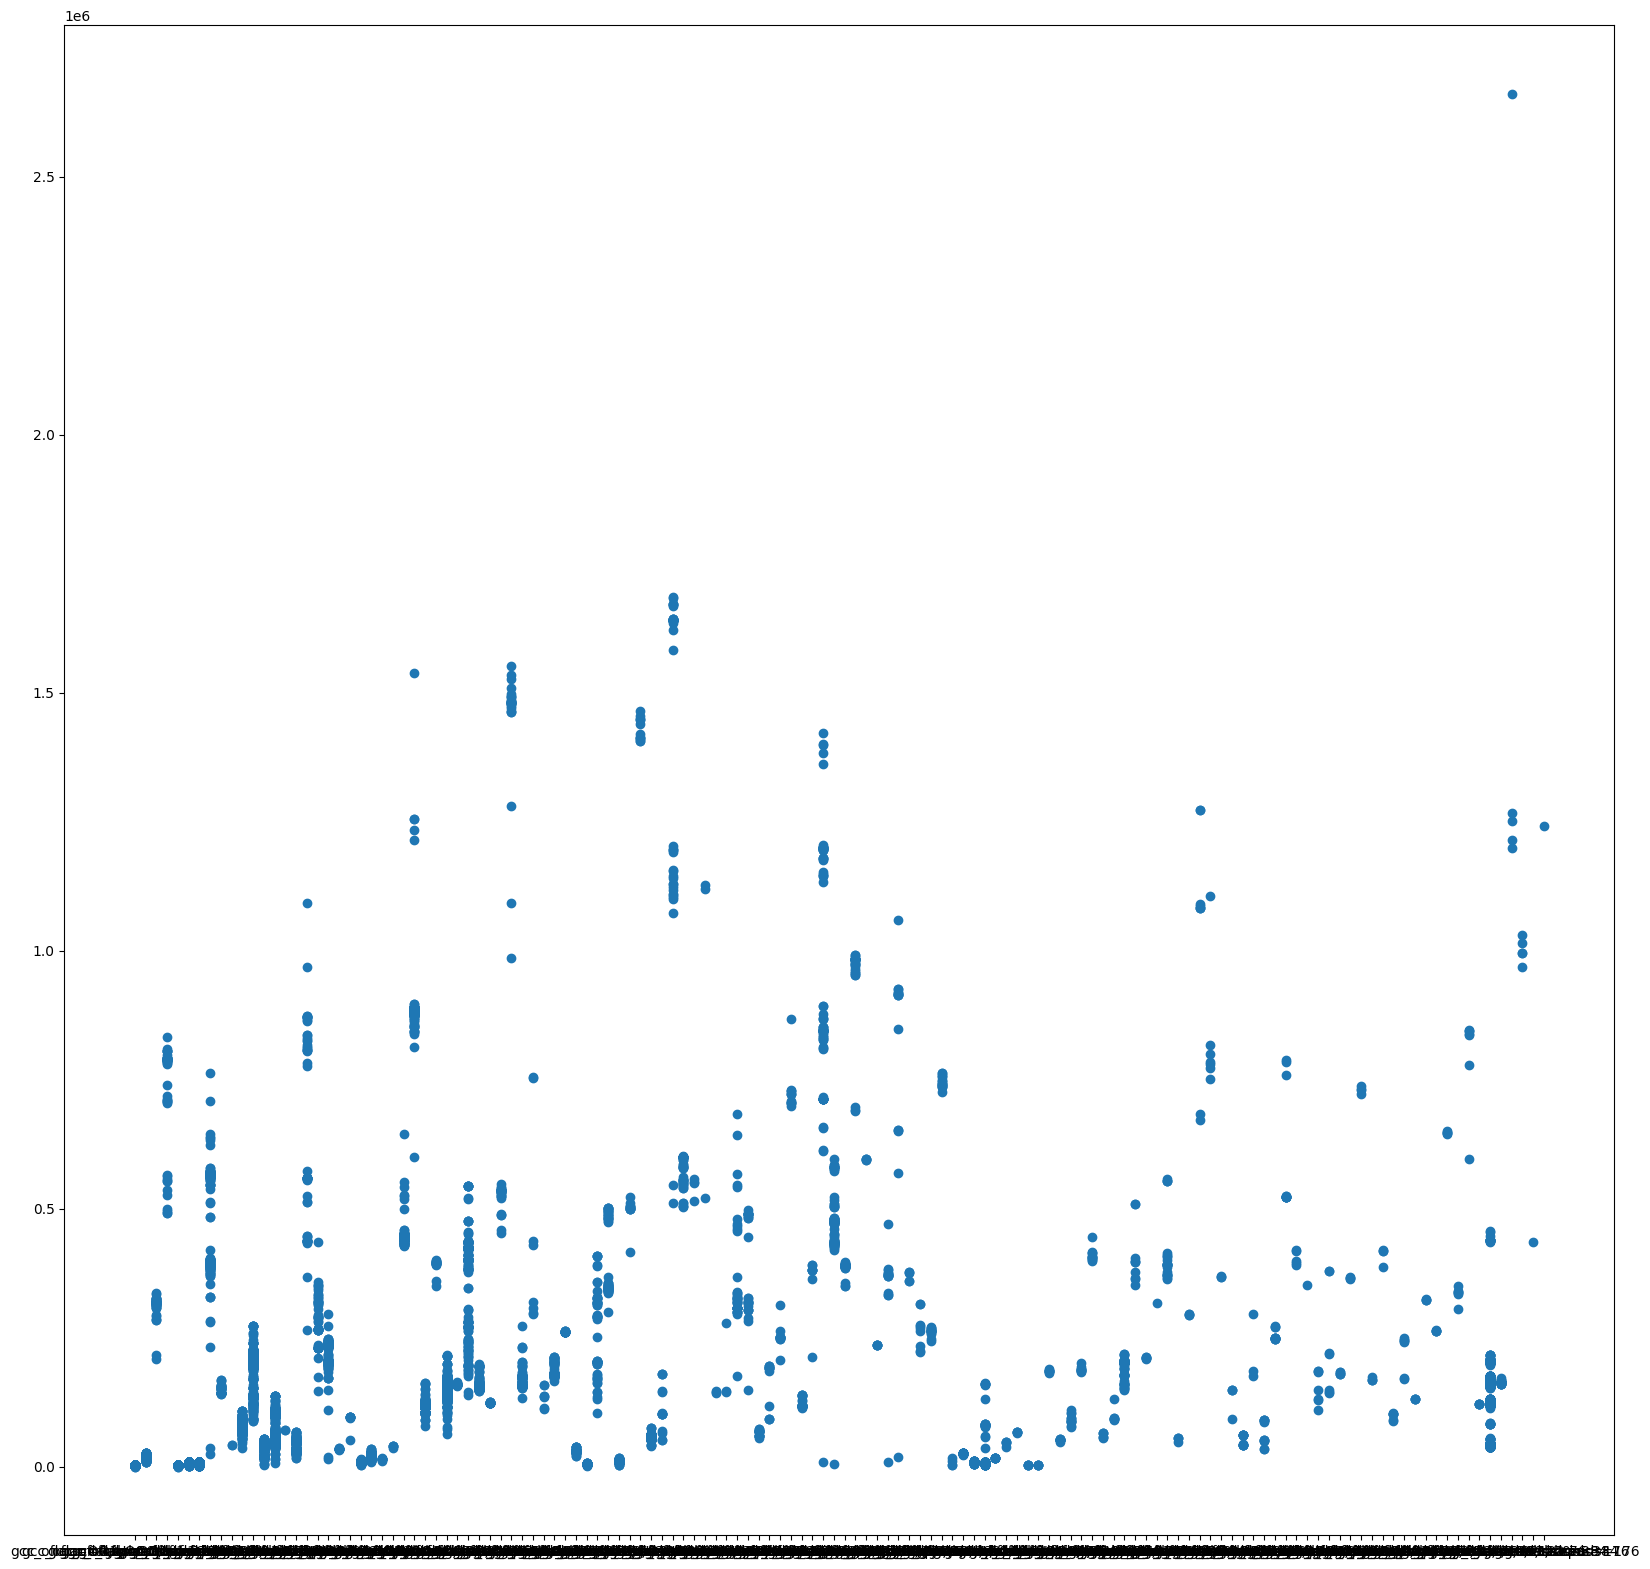

In [ ]:
plt.figure(figsize=(20, 20), dpi=100)
plt.scatter(value_x, value_y)
plt.show()

In [ ]:
# plt.figure(figsize=(200, 200), dpi=100)
# plt.scatter(value_x, value_y)
# plt.show()

## 自动调参

In [ ]:
# from sklearn import svm, datasets
# from sklearn.model_selection import RandomizedSearchCV
# import pandas as pd
# from scipy.stats import uniform

# # 定义超参搜索空间
# distributions = {'kernel':['linear','poly','rbf','sigmoid','precomputed'], 'C':uniform(loc=1, scale=9)}
# # 初始化模型
# svr = SVR()
# # 网格搜索
# clf = RandomizedSearchCV(estimator = svr,
#                          param_distributions = distributions,
#                          n_iter = 4,
#                          scoring = 'accuracy',
#                          cv = 5,
#                          n_jobs = -1,
#                          random_state = 2023)
# print("1")
# clf.fit(X_train, y_train)
# print("2")
# #ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [ ]:
# # 打印结果
# print('详细结果:\n', pd.DataFrame.from_dict(clf.cv_results_))
# print('最佳分类器:\n', clf.best_estimator_)
# print('最佳分数:\n', clf.best_score_)
# print('最佳参数:\n', clf.best_params_)
# # 返回：
# # 详细结果:
# #     mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  ... split3_test_score split4_test_score  mean_test_score  std_test_score  rank_test_score
# # 0       0.000598      0.000489         0.000200        0.000400   6.4538  ...          0.966667               1.0         0.986667        0.016330                1
# # 1       0.000997      0.000002         0.000000        0.000000  4.99782  ...          0.966667               1.0         0.980000        0.026667                3
# # 2       0.000798      0.000399         0.000399        0.000488  3.81406  ...          0.966667               1.0         0.980000        0.016330                3
# # 3       0.000598      0.000488         0.000200        0.000399  5.36286  ...          0.966667               1.0         0.986667        0.016330                1
# # [4 rows x 15 columns]
# # 最佳分类器:
# #  SVR(C=6.453804509266643)
# # 最佳分数:
# # 0.9866666666666667
# # 最佳参数:
# #  {'C': 6.453804509266643, 'kernel': 'rbf'}

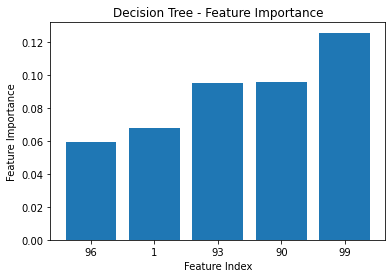

In [51]:
#展示出现次数
showCoef_new( decision_tree_reg)

In [67]:
resultCoef = getCoef(decision_tree_reg)
resultCoef

[[99, 90, 93, 1, 96, 71, 72, 2, 95, 84]]

In [68]:
def getFeatureName(X, result):
    feature_names = X.columns
    decision_tree_indices = result[0]  # 决策树模型的特征索引
    resDict={}
    if len(decision_tree_indices) > 0:
        print('decision_tree_reg_index: ', decision_tree_indices)
        decision_tree_feature_names = feature_names[decision_tree_indices].tolist()
        print('decision_tree_feature_names: ', decision_tree_feature_names)
        resDict['decision_tree_feature_names']=decision_tree_feature_names
    return resDict


In [69]:
FeatureImportDict=getFeatureName(X, resultCoef)

decision_tree_reg_index:  [99, 90, 93, 1, 96, 71, 72, 2, 95, 84]
decision_tree_feature_names:  ['results_key_gcc_oflag=O3,threads=256', 'results_key_gcc_oflag=O3,threads=192', 'results_key_gcc_oflag=O3,threads=208', 'results_key_gcc_oflag=O0,threads=1', 'results_key_gcc_oflag=O3,threads=232', 'results_key_gcc_oflag=O3,threads=1', 'results_key_gcc_oflag=O3,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O0,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O3,threads=224', 'results_key_gcc_oflag=O3,threads=152']


In [70]:
print(FeatureImportDict)

{'decision_tree_feature_names': ['results_key_gcc_oflag=O3,threads=256', 'results_key_gcc_oflag=O3,threads=192', 'results_key_gcc_oflag=O3,threads=208', 'results_key_gcc_oflag=O0,threads=1', 'results_key_gcc_oflag=O3,threads=232', 'results_key_gcc_oflag=O3,threads=1', 'results_key_gcc_oflag=O3,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O0,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O3,threads=224', 'results_key_gcc_oflag=O3,threads=152']}


In [71]:
flag = True

## 决策树的信息理解
x[14]<=0.5：表示该节点的分裂条件，其中 x[14] 表示特征的索引（通常是在训练数据中的列的索引），0.5 是用于划分特征值的阈值。这表示如果样本的第 14 个特征值小于或等于 0.5，则按照左子树的路径进行分裂，否则按照右子树的路径进行分裂。

mse = 123432345：表示该节点的均方误差（Mean Squared Error, MSE），是在该节点处使用的用于评估分裂效果的指标。MSE 是决策树模型常用的一个评估指标，用于衡量当前节点的预测误差。

samples = 35：表示在该节点处参与训练的样本数量，即经过该节点的样本数量。

value = 2132232：表示在该节点处的预测值，通常是该节点处样本的目标变量（或标签）的平均值。这个值可以作为决策树模型对样本的预测结果。

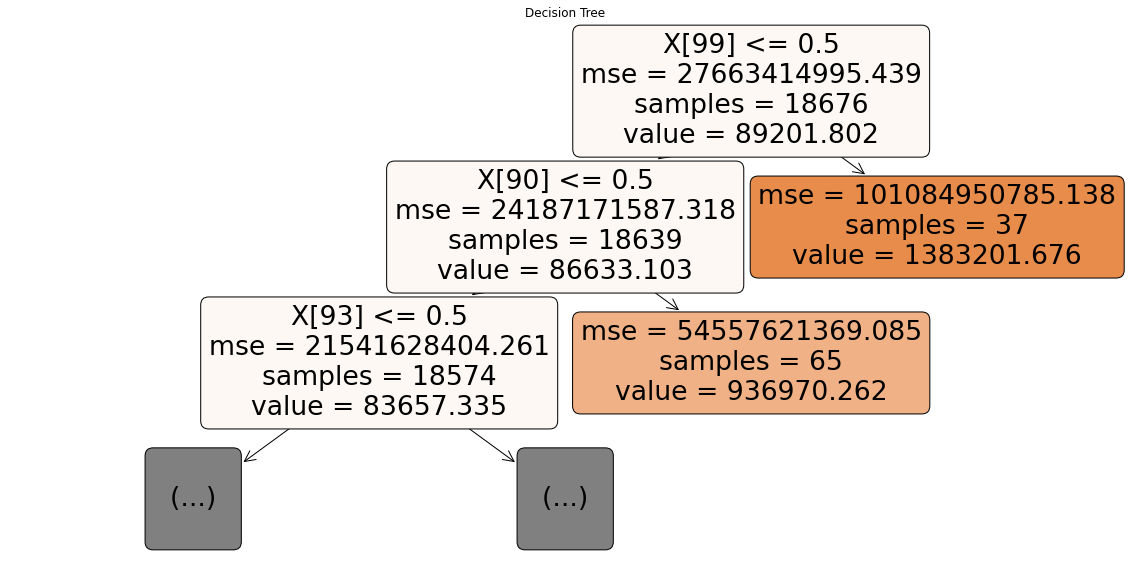

In [72]:
# 打印决策树
showDecisonTree(decision_tree_reg, flag)

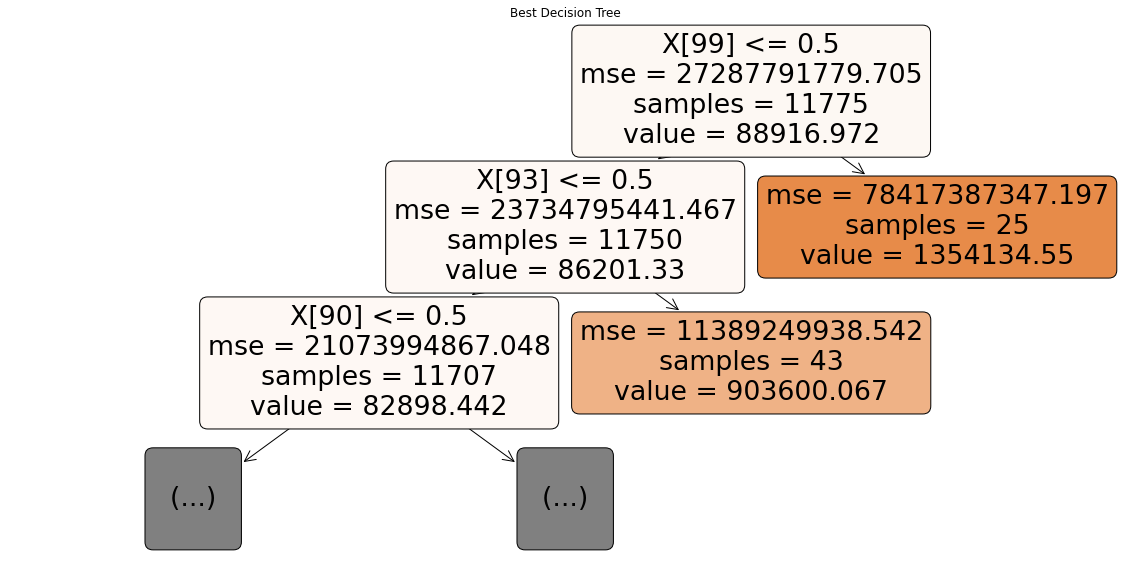

In [73]:
# 打印随机森林
showRandomForest(random_forest_reg, flag)

In [74]:
def processUnknowData1(testX):
    # processUnknowData1用于处理testX数据中所有的类别特征都在训练数据中出现过的情况
    testX_one_hot = pd.get_dummies(testX, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'])
    # 筛选出 testX_one_hot 中在 inputDF 中出现的列
    common_columns = testX_one_hot.columns.intersection(inputDF.columns)
    # 使用筛选后的列重新生成 testX
    testX = testX_one_hot[common_columns]

    # 将训练数据和测试数据合并后再进行独热编码
    combined_df = pd.concat([inputDF, testX], axis=0)
    one_hot_df = pd.get_dummies(combined_df, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'], dummy_na=False)

    # 分割合并后的数据，得到编码后的测试数据
    testX = one_hot_df.iloc[-1, :].values.reshape(1, -1)
    print(testX.shape)
    return testX


def processUnknowData2(testX):
    # processUnknowData2用于处理testX数据中可能包含了训练数据集中不存在的类别值
    testDict = {'cvm_cpu': '96', 'cvm_memory': '376', 'cvm_cpu_qos': 'cvm_cpu_qos', 'cvm_os_type': 'CentOS Linux release 7.6.181dsfsd0 (Core)', 'results_key': 'gcc_oflsdfsfdag=O3,threads=1'}

    for i, key in enumerate(testDict.keys()):
        testDict[key] = testX[i]

    max_key_length = max(len(key) for key in testDict.keys())
    for key, value in testDict.items():
        print('key: {:<{}} \tvalue: {}'.format(key, max_key_length, value))

    testDict = pd.DataFrame(testDict, index=[0])
    testDict['cvm_cpu'] = pd.to_numeric(testDict['cvm_cpu'])
    testDict['cvm_memory'] = pd.to_numeric(testDict['cvm_memory'])
    one_hot_df = pd.get_dummies(testDict, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'], dummy_na=False)

    # 获取 inputDF 中的特征列顺序
    inputDF_columns = X.columns.tolist()
    # 添加缺失的列，并将其值设置为 0
    missing_columns = list(set(inputDF_columns) - set(one_hot_df.columns))
    for column in missing_columns:
        one_hot_df[column] = 0

    # 按照 inputDF 列的顺序重新排列 one_hot_df
    one_hot_df = one_hot_df[inputDF_columns]

    # 确保编码后的维度与 inputDF 一致
    testX_encoded = one_hot_df.values.reshape(1, -1)
    print(testX_encoded.shape)
    return testX_encoded


def processData(testX, num):
    if num == 1:
        testX = processUnknowData1(testX)
    elif num == 2:
        testX = processUnknowData2(testX)
    else:
        print('num must be 1 or 2')
    return testX


In [75]:
testX = ['8','40','true','CentOS Linux release 7.3.1611 (Core)','gcc_oflag=O0,threads=1']
testY = 2364
testX_encoded = processData(testX, 2)

key: cvm_cpu     	value: 8
key: cvm_memory  	value: 40
key: cvm_cpu_qos 	value: true
key: cvm_os_type 	value: CentOS Linux release 7.3.1611 (Core)
key: results_key 	value: gcc_oflag=O0,threads=1
(1, 132)


C:\Users\zrz\AppData\Local\Temp/ipykernel_25868/2076153667.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_df[column] = 0
C:\Users\zrz\AppData\Local\Temp/ipykernel_25868/2076153667.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_df[column] = 0
C:\Users\zrz\AppData\Local\Temp/ipykernel_25868/2076153667.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [86]:
def predict(X, load_path):
    # 加载保存的模型
    model = [ 'decision_tree_reg', 'knn_reg', 'xgb_reg', 'gbdt_reg']
    result = []
    for model_name in model:
        with open(os.path.join(load_path, model_name + '.pkl'), 'rb') as f:
            models = pickle.load(f)
        preRes = models.predict(X)
        result.append(preRes)

    numbers = [item.item() if isinstance(item, np.ndarray) and item.size == 1 else item for sublist in result for item in sublist]

    predictions = {}
    for i in range(len(model)):
        predictions[model[i]] = numbers[i]

    return predictions


def plot_predictions(predictions, y):
    keys = list(predictions.keys())
    values = list(predictions.values())
    
    plt.figure(figsize=(20, 10))
    #plt.figure()

    # 生成 x 轴的位置
    ind = np.arange(len(keys))
    
    # 设置柱状图的宽度
    width = 0.35
    
    # 用 plt 画柱状图，x 轴是 predictions 的 key，y 轴是 predictions 的 value 和 y 的值，一个 x 轴对应两个柱子
    plt.bar(ind, values, width, label='Predictions')
    plt.bar(ind + width, y, width, label='Actual')
    
    # 设置 x 轴标签和标题
    plt.xticks(ind + width / 2, keys)
    plt.xlabel('Model')
    plt.ylabel('Value')
    plt.title('Model Predictions vs Actual Value')
    
    plt.legend()
    plt.show()

In [87]:
predictions = predict(testX_encoded, save_path)

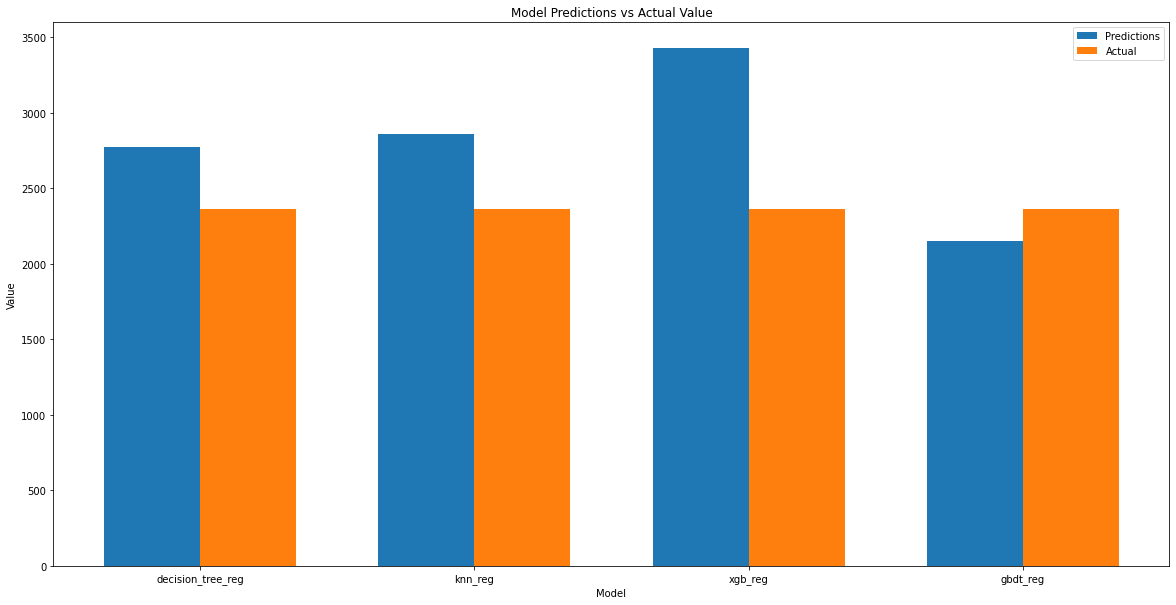

In [88]:
plot_predictions(predictions, testY)

## 多输出

In [142]:
def getMultiModel(X_train, y_train, save_path):
    # 初始化模型
    decision_tree_reg = DecisionTreeRegressor(splitter="best")  #“random”表示分枝时会更加随机，常用来防止过拟合
    knn_reg = KNeighborsRegressor(n_neighbors=7)    #应该是比较适合大量数据
    xgb_reg = xgb.XGBRegressor()
    #gbdt_reg=GradientBoostingRegressor()
    params = {
    'n_estimators': 400, 
    'max_depth': 11,
    'learning_rate': 0.06,
    'loss': 'ls',
    'subsample':0.8
     }
    gbdt_reg=GradientBoostingRegressor(**params)

    # 使用MultiOutputRegressor包装模型
    multioutput_decision_tree_reg = MultiOutputRegressor(decision_tree_reg)
    multioutput_knn_reg = MultiOutputRegressor(knn_reg)
    multioutput_xgb_reg = MultiOutputRegressor(xgb_reg)
    multioutput_gbdt_reg = MultiOutputRegressor(gbdt_reg)

    # 拟合模型
    multioutput_decision_tree_reg.fit(X_train, y_train)
    multioutput_xgb_reg.fit(X_train, y_train)
    multioutput_gbdt_reg.fit(X_train, y_train)
    multioutput_knn_reg.fit(X_train, y_train)

    # 保存模型
    models = {
        'multioutput_decision_tree_reg': multioutput_decision_tree_reg,
        'multioutput_xgb_reg': multioutput_xgb_reg,
        'multioutput_gbdt_reg': multioutput_gbdt_reg,
        'multioutput_knn_reg': multioutput_knn_reg,
    }
    # save_path = 'model/'
    for model_name, model in models.items():
        with open(save_path + model_name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

    return  multioutput_decision_tree_reg, multioutput_xgb_reg, multioutput_gbdt_reg, multioutput_knn_reg


def trainMulti(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    multioutput_decision_tree_reg, multioutput_xgb_reg, multioutput_gbdt_reg, multioutput_knn_reg = getMultiModel(X_train, y_train, save_path)

    # 预测
    y_pred_multioutput_decision_tree_reg = multioutput_decision_tree_reg.predict(X_test)
    y_pred_multioutput_xgb_reg = multioutput_xgb_reg.predict(X_test)
    y_pred_multioutput_gbdt_reg = multioutput_gbdt_reg.predict(X_test)
    y_pred_multioutput_knn_reg = multioutput_knn_reg.predict(X_test)

    # 计算评估指标
    r2_multioutput_decision_tree_reg = r2_score(y_test, y_pred_multioutput_decision_tree_reg)
    r2_multioutput_xgb_reg = r2_score(y_test, y_pred_multioutput_xgb_reg)
    r2_multioutput_gbdt_reg = r2_score(y_test, y_pred_multioutput_gbdt_reg)
    r2_multioutput_knn_reg = r2_score(y_test, y_pred_multioutput_knn_reg)
    
    print('{:<30} {}'.format('Multi-Output Decision Tree R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_decision_tree_reg))))
    print('{:<30} {}'.format('Multi-Output XGBoost Forest R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_xgb_reg))))
    print('{:<30} {}'.format('Multi-Output GBDT R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_gbdt_reg))))
    print('{:<30} {}'.format('Multi-Output KNN R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_knn_reg))))

    print('\n')


    #计算MAPE指标  越接近0模型越好,大于1就是劣质模型
    #Linear_MAPE = mean_absolute_percentage_error(y_test, y_pred_linear_reg)
    multioutput_Decision_tree_MAPE = mean_absolute_percentage_error(y_test, y_pred_multioutput_decision_tree_reg)
    multioutput_Knn_MAPE = mean_absolute_percentage_error(y_test, y_pred_multioutput_knn_reg)
    multioutput_xgb_MAPE = mean_absolute_percentage_error(y_test, y_pred_multioutput_xgb_reg)
    multioutput_gbdt_MAPE = mean_absolute_percentage_error(y_test, y_pred_multioutput_gbdt_reg)

    print('{:<30} {:>10}'.format('Multi-Output Decision Tree MAPE:', '{:.8f}'.format(multioutput_Decision_tree_MAPE)))
    print('{:<30} {:>10}'.format('Multi-Output KNN MAPE:', '{:.8f}'.format(multioutput_Knn_MAPE)))
    print('{:<30} {:>10}'.format('Multi-Output XGBOOST MAPE:', '{:.8f}'.format(multioutput_xgb_MAPE)))
    print('{:<30} {:>10}'.format('Multi-Output GBDT MAPE:', '{:.8f}'.format(multioutput_gbdt_MAPE)))
    print('\n')

In [184]:
def get_output_Speed(Tdf, field):
    df_input=[]
    df_output=[]
    # 选择需要提取的字段
    df = Tdf.copy()

    # 对dimension列进行预处理
    df['dimension'] = df['dimension'].apply(lambda x: json.loads(x))

    # # 对cvm_memory和cvm_cpu进行数值化处理
    # df[['cvm_cpu', 'cvm_memory']] = df[['cvm_cpu', 'cvm_memory']].apply(pd.to_numeric, errors='coerce').fillna(-1)

    # 筛选出符合要求的行
    df_filtered = df[df['results'].str.contains(field)]

    # 从results中提取出field对应的值
    df_output = pd.DataFrame(df_filtered['results'].apply(lambda x: json.loads(x)).tolist(), index=df_filtered.index)
    df_output = df_output[field]

    # 将input和output分别转成dataframe
    df_input = df_filtered['results_key']
    df_input = pd.DataFrame(df_input)
    df_output = pd.DataFrame(df_output)

    return df_input, df_output

In [187]:
your_field1 = '#unixbench_context'
your_field2 = '#unixbench_cpu'
inputDF1,outPutDF1 = get_output_Speed(df, your_field1)
inputDF2,outPutDF2 = get_output_Speed(df, your_field2)
inputDFMulti=inputDF1

outPutDF1.reset_index(drop=True,inplace=True)  #重置行索引
outPutDF2.reset_index(drop=True,inplace=True)
outputDFMulti = pd.concat([outPutDF1, outPutDF2], axis=1 , join='inner')
#outputDFMulti=pd.merge(outPutDF1, outPutDF2, left_index=True, right_index=True, how='outer')

print(inputDFMulti.shape)
print(outputDFMulti.shape)
print("finish")

(21923, 1)
(21923, 2)
finish


In [188]:
outputDFMulti.head()

,#unixbench_context,#unixbench_cpu
0,3321202,2364
1,323903,18835
2,2582968,3265
3,399481,317646
4,398895,788652


In [189]:
inputDFMulti.head()

,results_key
126,"gcc_oflag=O3,threads=16"
179,"gcc_oflag=O0,threads=1"
239,"gcc_oflag=O0,threads=8"
243,"gcc_oflag=O3,threads=1,which_core_to_bind=0"
257,"gcc_oflag=O0,threads=1,which_core_to_bind=0"


In [190]:
one_hot_df = pd.get_dummies(inputDFMulti, columns=['results_key'])
X = one_hot_df
y = outputDFMulti
print(X.shape)
print(y.shape)

(21923, 132)
(21923, 2)


In [191]:
save_path = 'model/'
# 判断是否有这个文件夹，没有就创建
if not os.path.exists(save_path):
    os.makedirs(save_path)

trainMulti(X, y, save_path)

Multi-Output Decision Tree R2: 0.43826357
Multi-Output XGBoost Forest R2: 0.43864074
Multi-Output GBDT R2:          0.43862299
Multi-Output KNN R2:           0.38649571


Multi-Output Decision Tree MAPE: 6.46813033
Multi-Output KNN MAPE:         5.46689420
Multi-Output XGBOOST MAPE:     6.63693093
Multi-Output GBDT MAPE:        6.39118915


